# Load pacakages
Use the standar packages from Google Colab unless stated otherwise.

----

Load necessary libraries and check the versions of the important ones.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle as pk
from google.colab import drive

# !pip install --upgrade tensorflow
# drive.mount('/content/gdrive', force_remount=True)

# sig1=np.load('/content/gdrive/My Drive/data1.npy')
# sig2=np.load('/content/gdrive/My Drive/data2.npy')

print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.3.0
1.18.5
1.1.3


# Load data function
In this problem, we are defining our dataset; X as random 5 numbers and y as sum of sine of X's and sum of cosine of X's.

In the training set, there are 16000 instances and in the test set, there are 160 instances.

In [ ]:
def loadTrainData (default_dir="/default/path/if/needed"):
  x = np.random.rand(16000,5) # write data loading procedures for train set
  y1 = np.array([np.sin(x).sum(axis=1)])
  y2 = np.array([np.cos(x).sum(axis=1)])
  y = np.concatenate((y1.T, y2.T), axis=1)
  # print(x.shape, y.shape) # just to check dimensions
  return x, y

def loadTestData (default_dir="/default/path/if/needed"):
  x = np.random.rand(160,5) # write data loading procedures for test set
  y1 = np.array([np.sin(x).sum(axis=1)])
  y2 = np.array([np.cos(x).sum(axis=1)])
  y = np.concatenate((y1.T, y2.T), axis=1)
  # print(x.shape, y.shape)
  return x , y

Check data loading function.

In [ ]:
loadTestData()

(array([[5.54903505e-01, 8.40938945e-01, 5.26292370e-01, 6.15694181e-01,
         2.94747863e-01],
        [5.21287126e-01, 7.35120535e-01, 7.23246225e-01, 5.00936441e-01,
         7.71381139e-01],
        [9.02328744e-01, 7.07188915e-01, 3.05570208e-01, 5.44349943e-02,
         6.57361465e-01],
        [8.31282516e-01, 5.08520760e-01, 6.43637711e-01, 2.87807400e-01,
         1.62950295e-01],
        [9.02043445e-01, 4.65152025e-01, 3.25964400e-02, 4.28115774e-01,
         2.55051206e-01],
        [2.37587821e-01, 1.04351251e-01, 7.97906932e-01, 9.06377809e-01,
         1.58162212e-01],
        [1.02544741e-01, 6.09728072e-01, 2.79295319e-01, 6.24490504e-01,
         7.32386801e-01],
        [1.91598206e-01, 1.35537938e-01, 9.33448675e-01, 4.75262419e-01,
         5.86791108e-01],
        [5.54311177e-01, 2.91972124e-01, 8.30451787e-02, 7.98355491e-01,
         7.23407148e-01],
        [4.13797176e-01, 4.19493622e-01, 3.53353176e-01, 7.13317439e-01,
         7.12090443e-01],
        [9

# Structure your model
Create a class to define and use a model

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model as Model_
from tensorflow.keras import regularizers

# define a model structure
class Model(Model_):
  def __init__(self, neurons=[12,12,3], reg=None): # define the structure with number of neurons in each hidden layer
    super(Model, self).__init__()
    self.denseLayers=[]
    for neuron in neurons: # for each hidden layer, add a dense layer of size with a number of neurons
      self.denseLayers.append(Dense(neuron, activation=None))
    #self.outputLayer = Dense(2, activation=None, kernel_regularizer = reg) # if we were to add regularization in the layer
    # self.regularizer = #can I also define regularizer as a separate hyperparameter?
    self.outputLayer = Dense(2, activation=None) # a final layer with 2 neurons and no activation function
  
  # to use the model 
  def call(self, input_x):
    output = input_x
    for layer in self.denseLayers:
      output = layer(output)
    return self.outputLayer(output)

# Create an optimization routine
Define optimization steps

In [ ]:
# optimizer defined with model, regularizer, minibatch, learning rate, and loss
class Optimizer:
  def __init__(self, model, reg = None, mb = 8, lr = 0.001, loss = tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam):
    self.model     = model
    #self.l1 = l1
    #self.l2 = l2
    self.reg = reg # regularization parameter as one of the hyperparameters
    self.loss      = loss() #tf.keras.losses.MeanSquaredError()
    self.optimizer = opt(learning_rate = lr)
    self.mb        = mb

    self.train_loss     = tf.keras.metrics.Mean(name='train_loss')
    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    self.test_loss     = tf.keras.metrics.Mean(name='test_loss')
    self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  
  @tf.function
  def train_step(self, x , y):
    with tf.GradientTape() as tape: # to watch the trainable variables of model and record the operations for performing automatic differentiation
      predictions = model(x)
      #loss = self.loss(y, predictions)
      loss = self.loss(y, predictions) + self.reg * tf.convert_to_tensor([tf.reduce_sum(abs(v)) for v in self.model.trainable_variables])
      # loss function for l1 regularization
      #loss = self.loss(y, predictions) + self.reg * tf.convert_to_tensor([tf.reduce_sum(square(v)) for v in self.model.trainable_variables])
      # loss function for l2 regularization
      #regularizer_loss = loss + tf.add_n(l2_model.losses)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_loss(loss)
    # self.train_accuracy(y, predictions)
    return loss

  @tf.function
  def test_step(self, x , y):
    predictions = self.model(x)
    #loss = self.loss(y, predictions)
    loss = self.loss(y, predictions) + self.reg * tf.convert_to_tensor([tf.reduce_sum(abs(v)) for v in self.model.trainable_variables])
    #loss = self.loss(y, predictions) + self.reg * tf.convert_to_tensor([tf.reduce_sum(abs(v)) for v in self.model.trainable_variables])
    self.test_loss(loss)
    # self.test_accuracy(y, predictions)

  def train (self):# for each mini batch, make predictions for train set and calculate loss (which is an average of the loss values in the batch)
    for mbX, mbY in self.train_ds:
      self.train_step(mbX, mbY)
  
  def test  (self): # for each mini batch, make predictions for test set and calculate loss (which is an average of the loss values in the batch)
    for mbX, mbY in self.test_ds:
      self.test_step(mbX, mbY)    
  
  def run   (self, dataX, dataY, testX, testY, epochs, verbose=2):
    historyTR = []
    historyTS = []
    template = '{} {}, {}: {}, {}: {}'
    # generate batches with the shuffled data from train set and from test set, respectively
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(16000).batch(self.mb)
    self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.mb)
    for i in range(epochs):
      
      self.train ()
    #   print(lossTR)
      self.test  ()
      # if verbose, print loss values for each epoch
      if verbose > 0:
        print(template.format("epoch: ", i+1,
                      " TRAIN LOSS: ", self.train_loss.result(),
                      " TEST LOSS: " , self.test_loss.result()))
                      # " TRAIN ACC: " , self.train_accuracy.result()*100,
                      # " TEST ACC: "  , self.test_accuracy.result()*100)
        # )
      
      temp = '{}'
      # append loss values for train and test loss histories
      historyTR.append(float(temp.format(self.train_loss.result())))
      historyTS.append(float(temp.format(self.test_loss.result() )))

      # has to reset states for each epoch
      self.train_loss.reset_states()
      self.train_accuracy.reset_states()
      self.test_loss.reset_states()
      self.test_accuracy.reset_states()
    return historyTR, historyTS # train loss values and test loss values

# Structure your calls
Here you should make the main calls

In [ ]:
x  , y  = loadTrainData ()
xt , yt = loadTestData  ()

# initiate a model instance
#model  = Model (reg='l1')
model  = Model ()
# initiate an optimzer instance to run
opt    = Optimizer (model, reg = 0.01, mb = 8, lr = 0.000001, loss = tf.keras.losses.MeanSquaredError, opt=tf.keras.optimizers.Adam)
# or just: $ opt    = Optimizer (model)

# get train and test loss values after running the optimizer
tr, ts = opt.run (x, y, xt, yt, 100, verbose=1)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch:  1,  TRAIN LOSS: : 8.839407920837402,  TEST LOSS: : 8.863236427307129
epoch:  2,  TRAIN LOSS: : 8.514732360839844,  TEST LOSS: : 8.549068450927734
epoch:  3,  TRAIN LOSS: : 8.192831993103027,  TEST LOSS: : 8.237239837646484
epoch:  4,  TRAIN LOSS: : 7.873526573181152,  TEST LOSS: : 7.927468299865723
epoch:  5,  TRAIN LOSS: : 7.556050777435303,  TEST LOSS: : 7.618978977203369
epoch:  6,  TRAIN LOSS: : 7.240401268005371,  TEST LOSS: : 7.312222957611084
epoch:  7,  TRAIN LOSS: : 6.927315711975098,  

In [ ]:
tf.keras.backend.set_floatx('float64')

# PLOT

3.2.2


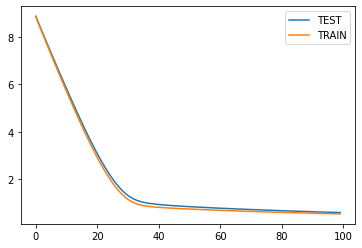

In [ ]:
# print train and test loss over epoch
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
plt.plot(ts, label='TEST')
plt.plot(tr, label='TRAIN')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DLLab/') # CHANGE THIS LINE DEPENDING OF WHERE YOU PUT YOUR FILES IN GOOGLE DRIVE

from run import run_experiment
run_experiment()

Mounted at /content/gdrive


ModuleNotFoundError: ignored